In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from glob import glob
import cv2
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## load testing data

In [3]:
class ImgDataset_test(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, filepath, transform=None):
        """
        Args:
            targets = dict that have bbox data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return len((self.filepath))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.filepath[idx]        
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        img_name = img_name.split('/')[-1]

        return image, img_name

In [4]:
test_image_dir = '../ivslab_test_public/JPEGImages/All/'
test_images = glob(test_image_dir+'*.jpg')

image_size = (800,800)

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor()])# [0-255] -> [0-1]


dataset_test = ImgDataset_test(test_images,transform)
print(dataset_test[0][1])
print(dataset_test[0][0].shape)

# 對 dataloader batch做最後處理的函式，不加會crash，原因我還沒搞懂
def collate_fn(batch):
    return tuple(zip(*batch))
testloader = DataLoader(dataset_test, batch_size=1,
                        shuffle=True, num_workers=0, collate_fn=collate_fn)

itp_775.jpg
torch.Size([3, 800, 800])


## create Model

In [5]:
model_ft = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 4+1
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## load Model

In [6]:
PATH = 'model/pytorch_fasterRCNN_10'

model_ft.load_state_dict(torch.load(PATH))
model_ft.eval() 
model_ft = model_ft.to(device)

In [7]:
outputs = list()

with torch.no_grad():
    for images, img_name in testloader:
        images = list(image.to(device) for image in images)
        output = model_ft(images)
        output = {k: v.to('cpu') for k, v in output[0].items()}
        output['name'] = img_name
        outputs.append(output)

In [8]:
outputs[0]

{'boxes': tensor([[337.8906, 179.4173, 496.8678, 572.4332],
         [  0.0000, 403.9791, 226.1352, 712.9791],
         [174.3632, 394.6808, 256.8041, 612.9613],
         [199.8442, 406.8202, 320.9250, 530.7993],
         [559.4071, 425.9667, 607.7985, 596.4448],
         [519.5343, 439.9747, 548.0917, 544.6768],
         [495.9199, 434.6848, 532.3345, 550.5245],
         [245.5797, 415.9899, 326.3738, 514.0843],
         [485.4591, 437.8642, 518.3418, 535.9860],
         [483.5791, 449.8597, 502.1743, 529.6885],
         [132.4765, 413.7204, 247.1418, 603.4021],
         [490.3008, 445.0274, 551.4969, 526.4444],
         [554.0007, 439.0926, 589.3523, 545.0576],
         [524.7378, 431.0617, 545.4049, 535.7052],
         [596.1335, 435.3568, 612.1827, 504.5162],
         [322.4889, 363.9136, 494.0938, 578.9224],
         [215.9904, 408.8662, 260.8474, 562.0655],
         [488.6793, 443.6624, 509.2415, 521.7704],
         [226.0935, 411.3324, 294.5202, 504.2062],
         [103.6733, 42

In [9]:
submission =  pd.DataFrame(columns = ["image_filename", "label_id", "x", "y", "w", "h", "confidence"])
output_dict = {'1':1, '2':2, '3':3, '4':4 }
threshold = 0.5

In [10]:
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 800

for idx in range(len(outputs)):

    #Converting tensors to array
    boxes = outputs[idx]['boxes'].data.cpu().numpy()
    scores = outputs[idx]['scores'].data.cpu().numpy()
    labels = outputs[idx]['labels'].data.cpu().numpy()
    name = outputs[idx]['name'][0]

    #Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]

    # int_to_class - labels
    labels_th = []
    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(output_dict[str(labels[x])])

    #Appending results to csv
    for y in range(len(boxes_th)):

        #Bboxes, classname & image name
        x1 = boxes_th[y][0] * ( 1920 / IMAGE_WIDTH )
        y1 = boxes_th[y][1] * ( 1080 / IMAGE_HEIGHT)
        w = (boxes_th[y][2] - boxes_th[y][0]) * ( 1920 / IMAGE_WIDTH )
        h = (boxes_th[y][3] - boxes_th[y][1]) * ( 1080 / IMAGE_HEIGHT)
        class_name = labels_th[y]
        confidence = scores_th[y]

        #Creating row for df
        row = {"image_filename" : name, "label_id" : class_name, "x" : x1, "y" : y1, "w" : w, "h" : h,"confidence":confidence }
        #Appending to df
        submission = submission.append(row, ignore_index = True)

submission = submission.sort_values(by=['image_filename']).reindex()
submission.to_csv('test.csv',index=False)

In [11]:
submission.head()

,image_filename,label_id,x,y,w,h,confidence
3751,itp_1.jpg,1,38.4,517.05,184.8,176.85,0.999700
3753,itp_1.jpg,1,456.0,558.90,108.0,56.70,0.998583
3754,itp_1.jpg,3,866.4,545.40,64.8,85.05,0.990293
3755,itp_1.jpg,2,1488.0,544.05,38.4,98.55,0.911576
3756,itp_1.jpg,2,1528.8,531.90,52.8,140.40,0.906131


## demo

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys
import random
from PIL import Image

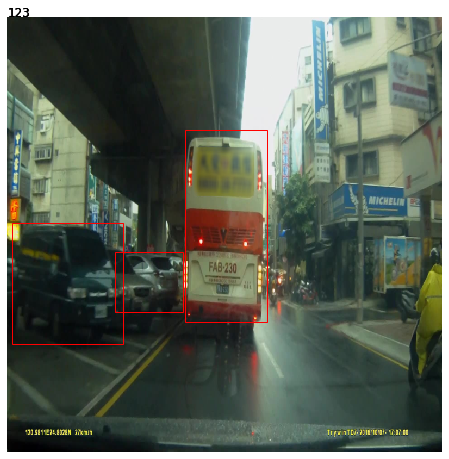

In [21]:
sample = [dataset_test[0][0].to(device)]
output = model_ft(sample)
output = [{k: v.to('cpu') for k, v in t.items()} for t in output]

sample_show = sample[0].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for pred in output:
    for box in pred['boxes'].detach().numpy().astype(np.int32)[0:3]:
            rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

ax.set_axis_off()


ax.imshow(sample_show)
plt.show()

In [14]:
dataset_test[0][1]

'itp_775.jpg'

In [15]:
submission.loc[submission['image_filename'] == 'itp_775.jpg']

,image_filename,label_id,x,y,w,h,confidence
4839,itp_775.jpg,1,475.2,583.20,297.6,149.85,0.996228
4842,itp_775.jpg,3,1756.8,544.05,160.8,433.35,0.948087
4845,itp_775.jpg,3,1130.4,623.70,28.8,78.30,0.563759
4838,itp_775.jpg,1,19.2,510.30,489.6,301.05,0.999733
4843,itp_775.jpg,3,1144.8,623.70,31.2,85.05,0.630841
4844,itp_775.jpg,3,1101.6,608.85,33.6,91.80,0.583083
4841,itp_775.jpg,1,328.8,575.10,355.2,201.15,0.951448
4837,itp_775.jpg,1,782.4,280.80,362.4,475.20,0.999985
4840,itp_775.jpg,3,1154.4,627.75,38.4,91.80,0.975260


In [16]:
submission.loc[submission['label_id'] == 3]

,image_filename,label_id,x,y,w,h,confidence
3754,itp_1.jpg,3,866.4,545.40,64.8,85.05,0.990293
2228,itp_100.jpg,3,1092.0,621.00,26.4,85.05,0.514472
2222,itp_100.jpg,3,1447.2,526.50,316.8,518.40,0.985474
2221,itp_100.jpg,3,1238.4,599.40,91.2,214.65,0.989350
2781,itp_1000.jpg,3,612.0,606.15,26.4,55.35,0.619455
...,...,...,...,...,...,...,...
4412,itp_997.jpg,3,1262.4,595.35,76.8,176.85,0.964802
7368,itp_998.jpg,3,1188.0,549.45,199.2,360.45,0.826992
5226,itp_999.jpg,3,1716.0,292.95,60.0,89.10,0.949043
5225,itp_999.jpg,3,1646.4,292.95,74.4,102.60,0.956984


In [3]:
def plot_result(filename, boxes, reshape=False) :
    filename = '../ivslab_test_public/JPEGImages/All/' + filename
    img = cv2.imread(filename)
    
    if reshape:
        img = cv2.resize(img,(IMAGE_WIDTH, IMAGE_HEIGHT))
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        box = box.astype(np.int32)
        rect = patches.Rectangle((box[0],box[1]),box[2],box[3],
                                    linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], '123', fontsize=12)

    ax.set_axis_off()
    print(img.shape)
    ax.imshow(img)

(1080, 1920, 3)


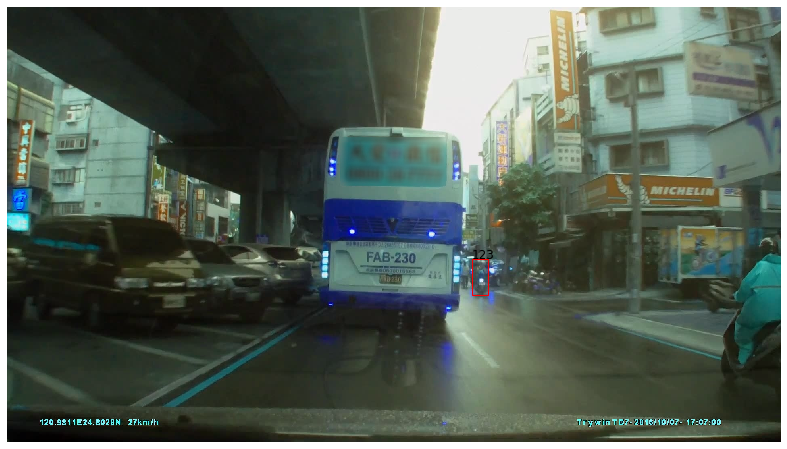

In [6]:
### original image
1154.4,625.05,40.8,91.80
boxes = np.array([[1154.4,625.05,40.8,91.80]])
filename = 'itp_775.jpg'
plot_result(filename,boxes)
draw_bbox

In [6]:
labels = ['vehicle', 'pedesrtrian', 'scooter', 'bicycle']

def draw_bbox(filename, bboxes, thres = 0.5, classes=labels, show_label=True):
    """
    bboxes: [x_min, y_min, w, h, confidence, label_id] format coordinates.
    """
    filename = '../ivslab_test_public/JPEGImages/All/' + filename
    image = cv2.imread(filename)
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        if score < thres:
            continue
        class_ind = int(bbox[5])-1
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[0]+coor[2], coor[1]+coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image

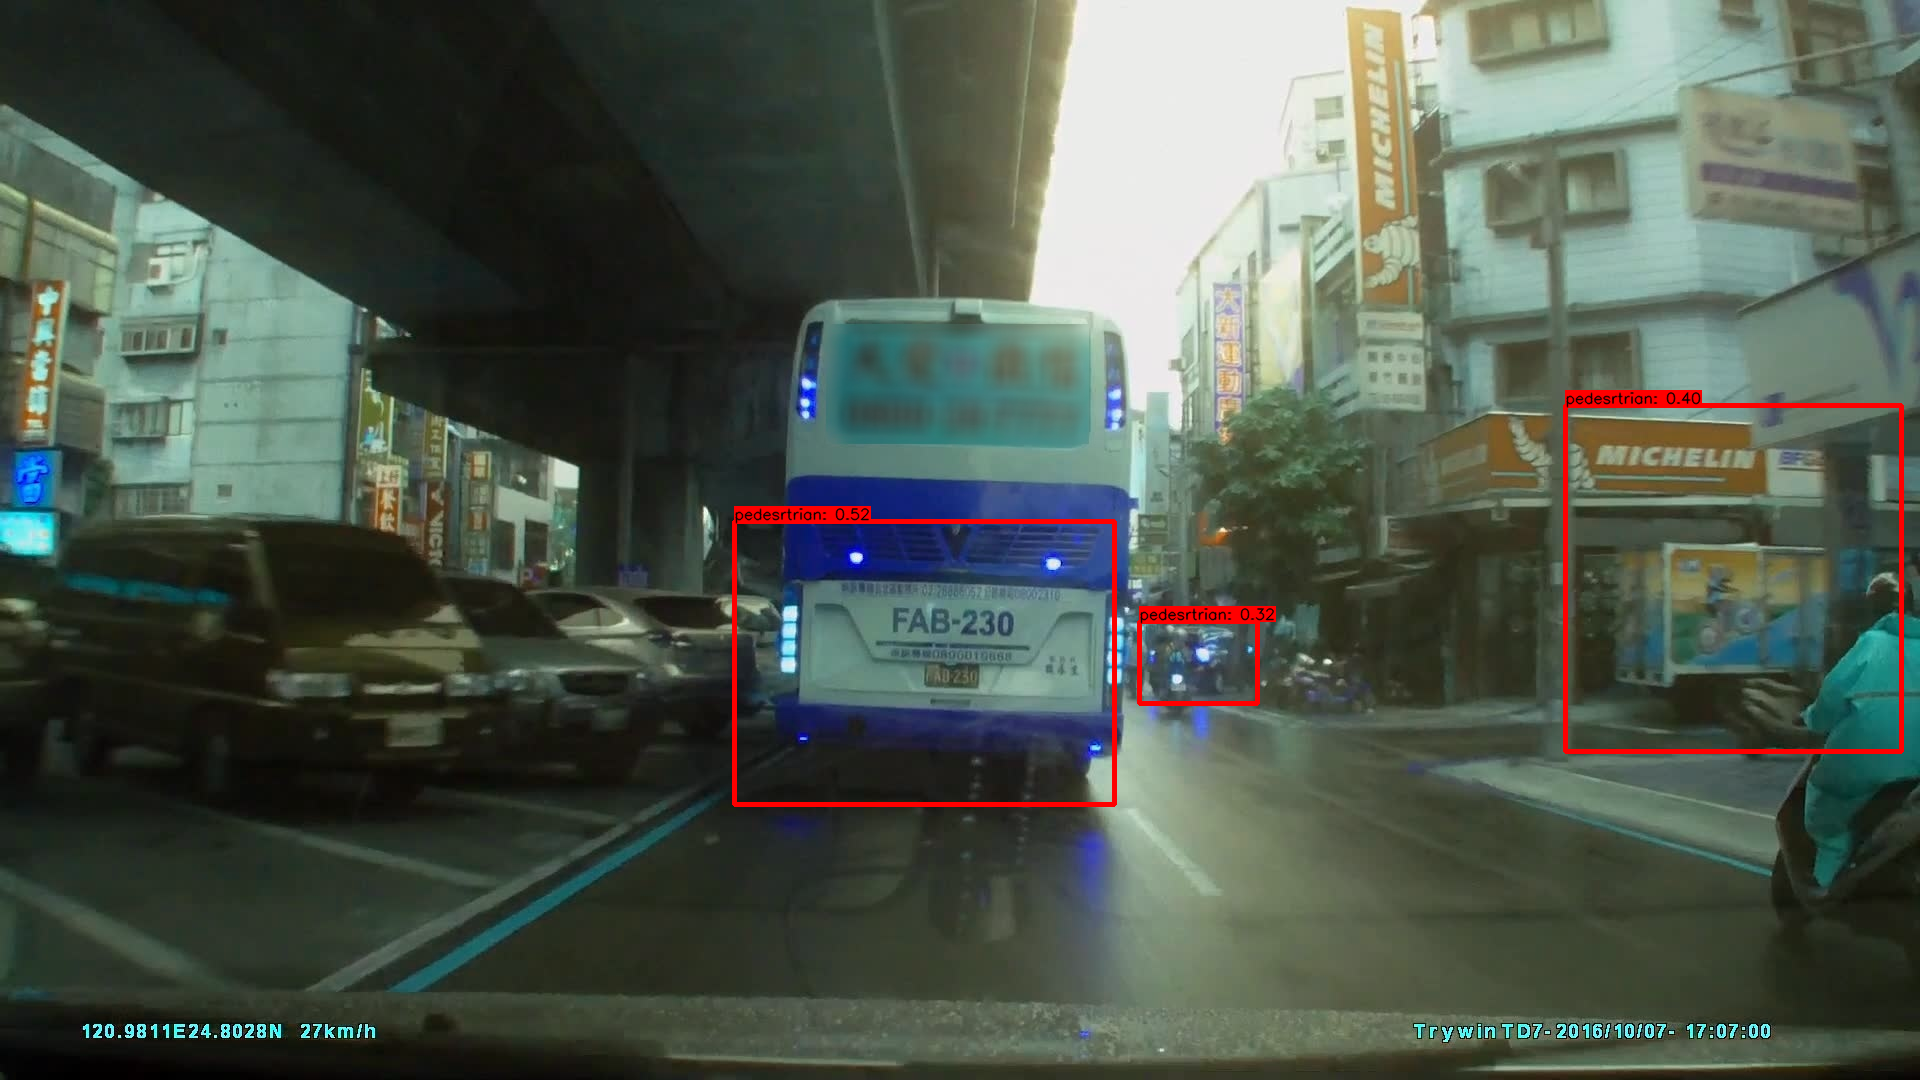

In [7]:
submission = pd.read_csv('OIFO.csv')
filename = 'itp_775.jpg'
boxes = submission.loc[submission['image_filename'] == filename][['x','y','w','h','confidence','label_id']].values
labels = ['vehicle', 'pedesrtrian', 'scooter', 'bicycle']
image = draw_bbox('itp_775.jpg',boxes,0,labels)
image = Image.fromarray(image)

image

In [8]:
submission.head()

,image_filename,label_id,x,y,w,h,confidence
0,itp_775.jpg,2,734,521,380,283,0.518942
1,itp_775.jpg,2,1565,405,336,346,0.395467
2,itp_775.jpg,2,1139,621,118,82,0.320603
3,itp_559.jpg,2,718,554,93,65,0.415528
4,itp_559.jpg,2,1362,462,304,200,0.410612


In [14]:
submission.loc[submission['label_id'] == 1]

,image_filename,label_id,x,y,w,h,confidence


In [15]:
! nvidia-smi

Sun Feb 28 12:21:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8    18W / 250W |   7036MiB /  7973MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------